<p align = "center" draggable=”false” ><img src="https://github.com/AI-Maker-Space/LLM-Dev-101/assets/37101144/d1343317-fa2f-41e1-8af1-1dbb18399719"
     width="200px"
     height="auto"/>
</p>

<h1 align="center" id="heading">AI Makerspace: Pydantic AI Event</h1>


Sou o <font color="pink">Senior Data Scientist.: Dr. Eddy Giusepe Chirinos Isidro</font> e aqui estudarei a Pydantic AI.


Links de estudo:

* [logfire](https://logfire.pydantic.dev/eddygiusepe/teste-ai-makerspace/settings/setup)
* [Anthropic](https://console.anthropic.com/settings/keys)

Neste evento apresentado por ``AI Makerspace``, construiremos um gerador de piadas usando a estrutura de IA do Pydantic!

A estrutura de IA do ``Pydantic`` é uma nova maneira de criar agentes com base nos trabalhos anteriores do ``Pydantic`` sobre validação de dados e modelos de dados.

Começaremos com nossas dependências:

In [ ]:
#!pip install -qU pydantic-ai logfire devtools

Precisaremos de algumas chaves de API para este exemplo:

Vamos aproveitar o novo agente "melhor vibração" para determinar se as piadas são hilárias - e o ``Claude 3.7 Sonnet`` para gerar algumas piadas iniciais.

In [1]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
#openai.api_key  = os.environ['OPENAI_API_KEY']
Eddy_key_openai  = os.environ['OPENAI_API_KEY']
Eddy_key_anthropic = os.environ['ANTHROPIC_API_KEY']
Eddy_key_logfire = os.environ['LOGFIRE_API_KEY']


Como estamos no notebook, precisaremos aninhar o asyncio para executar nosso código.

In [2]:
import nest_asyncio
nest_asyncio.apply()

GRANDE PAREDE DE DECLARAÇÕES DE IMPORTAÇÃO!

In [3]:
from __future__ import annotations as _annotations

from dataclasses import dataclass, field
from pathlib import Path
from typing import Annotated

import logfire
from devtools import debug
from pydantic_graph import BaseNode, Edge, End, Graph, GraphRunContext, HistoryStep

from pydantic_ai import Agent
from pydantic_ai.format_as_xml import format_as_xml
from pydantic_ai.messages import ModelMessage

Vamos usar o Logfire para rastrear nossos eventos!

Você pode se inscrever em uma conta gratuita em https://pydantic.dev/logfire!

In [4]:
logfire.configure(token=os.environ["LOGFIRE_API_KEY"])

Logfire project URL: 
]8;id=808514;https://logfire.pydantic.dev/eddygiusepe/teste-ai-makerspace\https://logfire.pydantic.dev/eddygiusepe/teste-ai-makerspace]8;;\


## Building our Agents!

Para construir um gerador de piadas multi-agente, precisaremos construir um par de agentes.

Vamos começar com nosso agente "Joke Generator".

> NOTE: O ``"instrument=True"`` é importante aqui. Isso permitirá que rastreemos os eventos no Logfire.

In [5]:
joke_generator_agent = Agent(
    "anthropic:claude-3-7-sonnet-latest",
    result_type=str,
    instrument=True
)

Então, similar a outros frameworks de agentes, queremos definir nosso estado.

> ``NOTE:`` Limitaremos a 5 tentativas para gerar uma piada, apenas no caso de Claude estar tendo um dia ruim.

In [6]:
@dataclass
class JokeState:
    joke: str | None = None
    joke_generator_agent_messages: list[ModelMessage] = field(default_factory=list)
    evaluate_agent_messages: list[ModelMessage] = field(default_factory=list)
    attempts: int = 0
    max_attempts: int = 5

Em seguida, vamos configurar nosso agente ``"Joke Generator"``, que será responsável por gerar piadas e incorporar feedback na geração de piadas.

Nosso ``JokeGenerator`` tomará nosso ``BaseNode`` com nosso ``JokeState``, e retornará um ``Evaluate`` node.

Este é o caminho que podemos produzir nosso gráfico! Podemos encadear nossos nós para produzir um gráfico - incluindo, como veremos, lógica condicional - assim como em ``LangGraph``!

In [7]:
@dataclass
class JokeGenerator(BaseNode[JokeState]):
    feedback: str | None = None

    async def run(self, ctx: GraphRunContext[JokeState]) -> Evaluate:
        ctx.state.attempts += 1

        prompt = 'Invente uma piada sobre gatos. Ela deve ser engraçada e interessante.'

        if self.feedback:
            prompt = f"""Invente uma piada sobre gatos. Ela deve ser engraçada e interessante.

Tentativa anterior: {ctx.state.joke}

Feedback na tentativa anterior: {self.feedback}

Por favor, crie uma nova piada que aborde este feedback."""

        result = await joke_generator_agent.run(
            prompt,
            message_history=ctx.state.joke_generator_agent_messages,
        )
        ctx.state.joke_generator_agent_messages += result.all_messages()
        ctx.state.joke = result.data

        return Evaluate()

Em seguida, podemos produzir outro nó que será responsável por iniciar nosso processo de avaliação.

In [8]:
@dataclass
class ProducedJoke(BaseNode[JokeState]):
    joke: str | None = None

    async def run(self, ctx: GraphRunContext[JokeState]) -> Evaluate:
        assert self.joke is not None
        return Evaluate(self.joke)

Precisaremos criar algum estado de avaliação, que ajudará o LLM a determinar como responder.

In [11]:
@dataclass
class EvaluationResult:
    dope: bool
    funny: bool
    comment: str

Nosso agente de avaliação será um modelo ``GPT-4.5 preview``, que será responsável por avaliar a piada. Estamos usando este modelo porque, embora não seja ótimo para raciocínio, é ótimo para ser engraçado!

In [12]:
evaluate_agent = Agent(
    'openai:gpt-4.5-preview',
    result_type=EvaluationResult,
    system_prompt='Dado uma piada, avalie se a piada é engraçada ou não - também avalie se a piada é engraçada. Ela precisa ser *muito* boa. Sugira melhorias na piada se não for.',
)

Agora vamos criar nosso ``Evaluate`` node.

Observe como estamos retornando um ``Congratulate`` ou ``Reprimand`` node, dependendo da avaliação - isso é como adicionamos complexidade ao nosso gráfico.

In [13]:
@dataclass
class Evaluate(BaseNode[JokeState]):
    async def run(
        self,
        ctx: GraphRunContext[JokeState],
    ) -> Congratulate | Reprimand | End:
        assert ctx.state.joke is not None

        result = await evaluate_agent.run(
            format_as_xml({'joke': ctx.state.joke}),
            message_history=ctx.state.evaluate_agent_messages,
        )
        ctx.state.evaluate_agent_messages += result.all_messages()

        if ctx.state.attempts >= ctx.state.max_attempts:
            print(f"Reached maximum attempts ({ctx.state.max_attempts}). Best joke so far: {ctx.state.joke}")
            print(f"Final feedback: {result.data.comment}")
            return End(None)

        if result.data.funny and result.data.dope:
            return Congratulate(result.data.comment)
        else:
            return Reprimand(result.data.comment)

Em seguida, vamos criar nosso ``Congratulate`` e ``Reprimand`` nodes.

Estes são nossos estados de ``"sucesso"`` e ``"falha"`` - eles serão usados para determinar o próximo nó em nosso gráfico.

`End` se a piada for boa.

In [14]:
@dataclass
class Congratulate(BaseNode[JokeState, None, None]):
    comment: str

    async def run(
        self, ctx: GraphRunContext[JokeState]
    ) -> Annotated[End, Edge(label='success')]:
        print(f'Encontrei uma piada engraçada e interessante após {ctx.state.attempts} tentativas!')
        print(f'Piada: {ctx.state.joke}')
        print(f'Feedback: {self.comment}')
        return End(None)

`Reprimand` se a piada precisa de melhorias.

In [15]:
@dataclass
class Reprimand(BaseNode[JokeState]):
    comment: str

    async def run(self, ctx: GraphRunContext[JokeState]) -> JokeGenerator:
        print(f'Tentativa {ctx.state.attempts}: {ctx.state.joke}')
        print(f'Feedback: {self.comment}')
        return JokeGenerator(feedback=self.comment)

Por fim, vamos criar nosso gráfico!

Observe que podemos apenas colocar os nós, conforme definimos suas conexões em cada nó.

In [16]:
question_graph = Graph(
    nodes=(JokeGenerator, Evaluate, Congratulate, Reprimand), state_type=JokeState
)

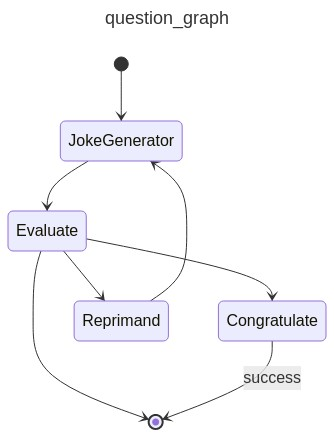

In [17]:
from IPython.display import Image, display

display(Image(question_graph.mermaid_image(start_node=JokeGenerator)))

Por fim, podemos executar nosso gráfico - é tão fácil quanto executar o próximo nó em um loop até que atinjamos o nó ``End``!

In [18]:
async def run_automated_joke_generator():
    state = JokeState()
    node = JokeGenerator()
    history: list[HistoryStep[JokeState, None]] = []
    with logfire.span('run automated joke generator'):
        while True:
            node = await question_graph.next(node, history, state=state)
            if isinstance(node, End):
                debug([e.data_snapshot() for e in history])
                break

result = await run_automated_joke_generator()

03:17:09.845 run automated joke generator
03:17:09.887   run node JokeGenerator
03:17:09.888     joke_generator_agent run
03:17:09.889       preparing model request params
03:17:09.889       chat claude-3-7-sonnet-latest


ModelHTTPError: status_code: 400, model_name: claude-3-7-sonnet-latest, body: {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'Your credit balance is too low to access the Anthropic API. Please go to Plans & Billing to upgrade or purchase credits.'}}